# Age prediction males with informative region

Final jupyter notebook for age prediction using infrared spectrosocpy data from tsetse males

## Changelog

### 2023-11-03

#### Modified

- Deleted non-used code
- Plots have been renamed

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:

import sys

import pandas as pd
import seaborn as sn
import matplotlib.pyplot as plt
import numpy as np


from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.metrics import ConfusionMatrixDisplay
from sklearn.metrics import classification_report
from sklearn.metrics import roc_auc_score


sys.path.append('../src')
from utilities import baseline_accuracy
from utilities import dataplotmelt
from utilities import test_model

from utilities import montecarlo_crossvalidation
from utilities import model_optimization
from utilities import variable_importance_df


In [3]:
colors = sn.color_palette("Set2") 

In [5]:
tsetse_data = pd.read_csv("../data/raw/TseTse_finaldatasetclean.csv")
tsetse_data.rename(columns={"Cat1":"Plate", "Cat3":"Sex", "Cat4":"Age", "Cat5":"Tissue"}, inplace=True)
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("T", 'Thorax')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("H", 'Head')
tsetse_data['Tissue'] = tsetse_data['Tissue'].str.replace("A", 'Abdomen')

In [6]:
tsetse_data_copy = tsetse_data.copy()

In [7]:
tsetse_males_thorax = tsetse_data_copy.loc[(tsetse_data_copy['Sex'] == 'm') & (tsetse_data_copy['Tissue'] == 'Thorax')]

tsetse_males_head = tsetse_data_copy.loc[(tsetse_data_copy['Sex'] == 'm') & (tsetse_data_copy['Tissue'] == 'Head')]

In [8]:
tsetse_males_thorax.groupby("Age")["ID"].count()

Age
5w    93
7w    92
Name: ID, dtype: int64

In [9]:
tsetse_males_head.groupby("Age")["ID"].count()

Age
5w    94
7w    93
Name: ID, dtype: int64

In [10]:
tsetse_males_thorax_copy = tsetse_males_thorax.copy()
tsetse_males_head_copy = tsetse_males_head.copy()

## Age prediction males

In [11]:
X_thorax = tsetse_males_thorax.loc[:,"1800":"602"]
y_thorax = tsetse_males_thorax.loc[:,"Age"]

X_head = tsetse_males_head.loc[:,"1800":"602"]
y_head = tsetse_males_head.loc[:,"Age"]

waveNumslist_reduced = X_thorax.columns.values.tolist()
wavenumbers_reduced = [int(x) for x in waveNumslist_reduced]

In [12]:
X_th_train, X_th_test, y_th_train, y_th_test = train_test_split(X_thorax, y_thorax, test_size=0.2, shuffle=True, random_state=123)

X_hd_train, X_hd_test, y_hd_train, y_hd_test = train_test_split(X_head, y_head, test_size=0.2, shuffle=True, random_state=123)

In [13]:
females_thorax_acc_baseline = baseline_accuracy(X_th_train, y_th_train)
females_head_acc_baseline = baseline_accuracy(X_hd_train,y_hd_train)

Fitting 10 folds for each of 4 candidates, totalling 40 fits
Fitting 10 folds for each of 4 candidates, totalling 40 fits


In [14]:
data_plot_thorax = dataplotmelt(females_thorax_acc_baseline)
data_plot_head = dataplotmelt(females_head_acc_baseline)

In [15]:
output = data_plot_head.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.646667  0.094542
1        LR  0.850000  0.057198
2        RF  0.723333  0.060959
3       SVC  0.726667  0.066295


In [16]:
output = data_plot_thorax.groupby(['param_clf'], as_index=False).agg({'value':['mean','std']})
print(output)

  param_clf     value          
                 mean       std
0      CART  0.696667  0.053171
1        LR  0.820000  0.059213
2        RF  0.736667  0.085274
3       SVC  0.786667  0.059213


In [17]:
# model optimization

# Head
best_model_head = model_optimization(X_hd_train,y_hd_train)


Best model parameters{'model__C': 10, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [18]:
# thorax

best_mdoel_thorax = model_optimization(X_th_train, y_th_train)

Best model parameters{'model__C': 100, 'model__penalty': 'l2', 'model__solver': 'newton-cg'}


In [19]:
# test head

y_head_pred, y_head_prob, pipe_head = test_model(X_hd_train, X_hd_test, y_hd_train, best_model_head)
y_thorax_pred, y_thorax_prob, pipe_thorax = test_model(X_th_train, X_th_test, y_th_train, best_mdoel_thorax)

In [20]:
accuracy_head = accuracy_score(y_hd_test, y_head_pred)
accuracy_thorax = accuracy_score(y_th_test, y_thorax_pred)
print(f"Accuracy on test set: {accuracy_head}")
print(f"Accuracy on test set: {accuracy_thorax}")

Accuracy on test set: 0.9736842105263158
Accuracy on test set: 0.8378378378378378


In [21]:
report_head = classification_report(y_hd_test, y_head_pred, output_dict=True)
report_head = pd.DataFrame(report_head).transpose()
report_head["Tissue"] = "Head"

In [22]:
report_thorax = classification_report(y_th_test, y_thorax_pred, output_dict=True)
report_thorax = pd.DataFrame(report_thorax).transpose()
report_thorax["Tissue"] = "Thorax"

In [23]:
report_males_age_informative = pd.concat([report_head, report_thorax])

report_males_age_informative.to_excel("../results/tables/informative_region_results/report_males_age_informative.xlsx")

In [24]:
top20_head = variable_importance_df(wavenumbers_reduced, best_model_head)
top20_thorax = variable_importance_df(wavenumbers_reduced, best_mdoel_thorax)

In [25]:
top20_thorax

,Wavenumbers,Coefficients
22,1756,4.929739
17,1766,3.704480
21,1758,3.699632
18,1764,3.667899
343,1114,2.453589
342,1116,2.358417
341,1118,2.358417
507,786,2.283714
508,784,2.283435
52,1696,2.256942


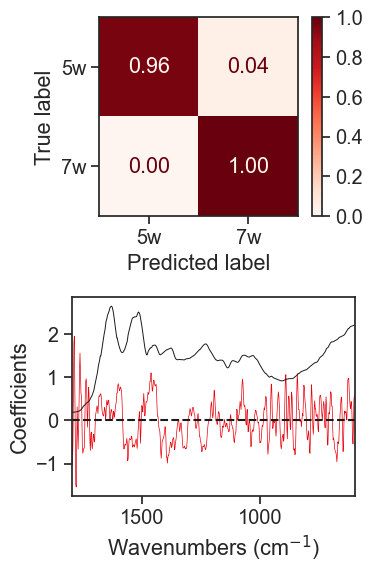

In [26]:
# final plot
# confusion matrix and ocnefficients of the head

sn.set(font_scale=1.3)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(2,1, figsize=(4,6), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_hd_test,y_head_pred,display_labels=pipe_head.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0., 'vmax':1.})

sn.lineplot(x=wavenumbers_reduced,y=best_model_head['model'].coef_[0], color='r',ax=ax2, linewidth=0.5)
ax2.axhline(y=0, color="k", ls="--")
ax2.set_xlim(1800,600)
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")
ax2.set_ylabel("Coefficients")

sn.lineplot(x=wavenumbers_reduced,y=np.mean(X_head, axis=0)*9, color='k',ax=ax2, linewidth=0.7)

plt.savefig("../results/plots/Fig5_age_males_head_informative.png", dpi=900)





In [27]:
topwavenumbers = variable_importance_df(wavenumbers_reduced,best_model_head)
topwavenumbers

,Wavenumbers,Coefficients
6,1788,1.945759
5,1790,1.764352
18,1764,1.555167
17,1766,1.177562
168,1464,1.096210
169,1462,1.093712
478,844,1.081539
454,892,1.057962
19,1762,1.053931
453,894,0.996315


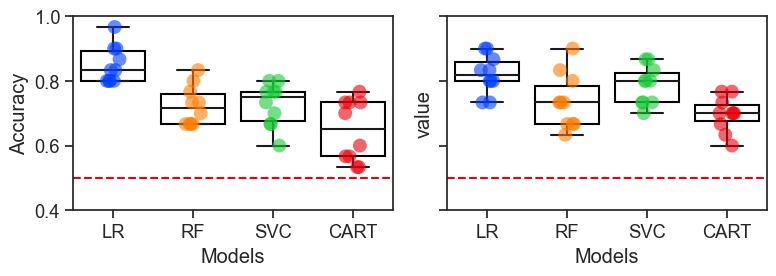

In [29]:
# suplementary material training


sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, ((ax,ax2)) = plt.subplots(1,2, figsize=(8,3), tight_layout=True, sharey=True)


sn.boxplot(data=data_plot_head, x='param_clf', y='value',ax=ax, color='white')
sn.stripplot(data=data_plot_head, x='param_clf',y='value', ax=ax,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax.lines, color='k')
ax.axhline(0.5, color='r',ls='--')


sn.boxplot(data=data_plot_thorax, x='param_clf', y='value',ax=ax2, color='white')
sn.stripplot(data=data_plot_thorax, x='param_clf',y='value', ax=ax2,
            size = 10,
           alpha = 0.6,            
           hue='param_clf',
            legend=False)
plt.setp(ax2.lines, color='k')
ax.set_ylim(0.4,1)
ax.set_xlabel("Models")
ax.set_ylabel("Accuracy")
for i,box in enumerate(ax.patches):
    box.set_edgecolor('black')


plt.setp(ax2.lines, color='k')
ax2.axhline(0.5, color='r',ls='--')
ax2.set_ylim(0.4,1)
ax2.set_xlabel("Models")
for i,box in enumerate(ax2.patches):
    box.set_edgecolor('black')


plt.savefig("../results/plots/males_age_training_informative_suplementary.png", dpi=300)

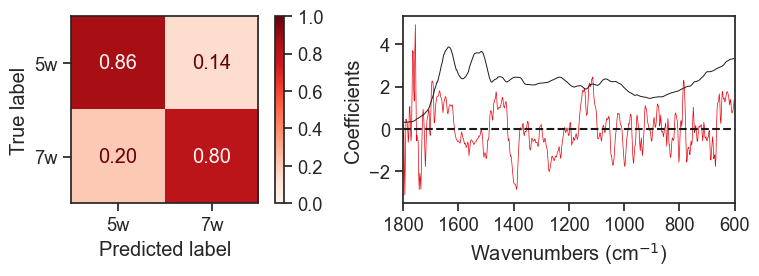

In [31]:
sn.set(font_scale=1.2)
sn.set_style("ticks")
sn.set_palette('bright', color_codes=True)

fig, (ax, ax2) = plt.subplots(1,2, figsize=(8,3), tight_layout=True)

disp = ConfusionMatrixDisplay.from_predictions(y_th_test,y_thorax_pred,display_labels=pipe_thorax.classes_, normalize='true', values_format='.2f', cmap=plt.cm.Reds, ax=ax, im_kw={'vmin':0., 'vmax':1.})

sn.lineplot(x=wavenumbers_reduced,y=best_mdoel_thorax['model'].coef_[0], color='r',ax=ax2, linewidth=0.5)
ax2.axhline(y=0, color="k", ls="--")
ax2.set_xlim(1800,600)
ax2.set_xlabel("Wavenumbers (cm$^{-1}$)")
ax2.set_ylabel("Coefficients")
ax2.set_ylabel("Coefficients")

sn.lineplot(x=wavenumbers_reduced,y=np.mean(X_thorax, axis=0)*14, color='k',ax=ax2, linewidth=0.7)

plt.savefig("../results/plots/age_males_head_informative_suplementary.png", dpi=300)

In [135]:
accuracy_head_mc, a, b = montecarlo_crossvalidation(X_head, y_head, best_model_head, binary=True)

shuffle split: 100%|██████████| 100/100 [00:06<00:00, 14.70it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.86 ± 0.06


In [136]:
accuracy_thorax_mc, a, b = montecarlo_crossvalidation(X_thorax, y_thorax, best_mdoel_thorax, binary=False)

shuffle split: 100%|██████████| 100/100 [00:06<00:00, 14.69it/s]

Model perfomance using monte carlo cross-validation
Mean accuracy = 0.91 ± 0.05
